### First read the data and the images from the dataset along with camera intrinsics and camera extrinsics like rotation and translation.

In [1]:
import os
import numpy as np
import cv2
from utils import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:11: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.0)
  from scipy.sparse import csr_matrix, issparse


In [2]:
base_path = "/home/rafay/Documents/rafay/MyFolder_other_stuff/Educational/Vibot/M1/CV_fofi/incremental_sfm_vibot"
dataset_path = "dino"

In [3]:
img_params = get_img_params(base_path, dataset_path)

# Read images from the dataset
images = get_images(
    base_path, dataset_path, "gray"
)  # color for BGR and gray for grayscale

images_and_params = np.array([[param, img] for param, img in zip(img_params, images)])

/tmp/ipykernel_209517/615899425.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images_and_params = np.array([[param, img] for param, img in zip(img_params, images)])


In [4]:
feature_descriptors = [get_sift_features(image) for image in images_and_params[:,1]]

In [5]:
matches_flann_sift_good_matches_flann_sift = [match_features_flann(
    feature_descriptors[0][1], feature_descriptors[1][1], "sift"
) for i in range(len(images))]

FLANN SIFT Matcher: 132 matches found, 106 after ratio test.
FLANN SIFT Matcher: 132 matches found, 107 after ratio test.
FLANN SIFT Matcher: 132 matches found, 106 after ratio test.
FLANN SIFT Matcher: 132 matches found, 106 after ratio test.
FLANN SIFT Matcher: 132 matches found, 106 after ratio test.
FLANN SIFT Matcher: 132 matches found, 106 after ratio test.
FLANN SIFT Matcher: 132 matches found, 106 after ratio test.
FLANN SIFT Matcher: 132 matches found, 106 after ratio test.
FLANN SIFT Matcher: 132 matches found, 106 after ratio test.
FLANN SIFT Matcher: 132 matches found, 107 after ratio test.
FLANN SIFT Matcher: 132 matches found, 106 after ratio test.
FLANN SIFT Matcher: 132 matches found, 107 after ratio test.
FLANN SIFT Matcher: 132 matches found, 106 after ratio test.
FLANN SIFT Matcher: 132 matches found, 106 after ratio test.
FLANN SIFT Matcher: 132 matches found, 106 after ratio test.
FLANN SIFT Matcher: 132 matches found, 106 after ratio test.
FLANN SIFT Matcher: 132 

In [6]:
matches_flann_sift, good_matches_flann_sift = matches_flann_sift_good_matches_flann_sift[0]

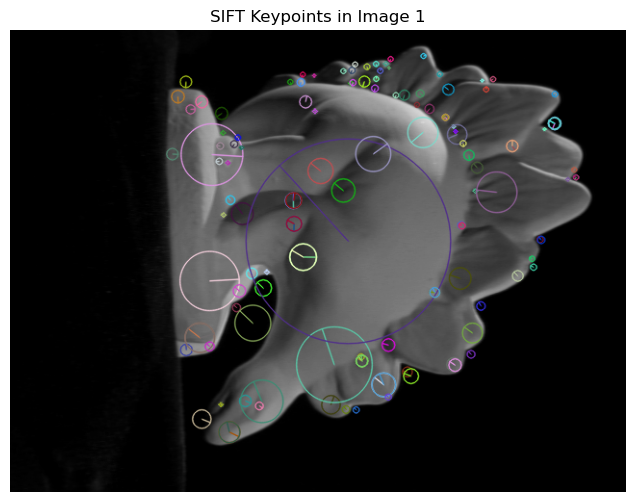

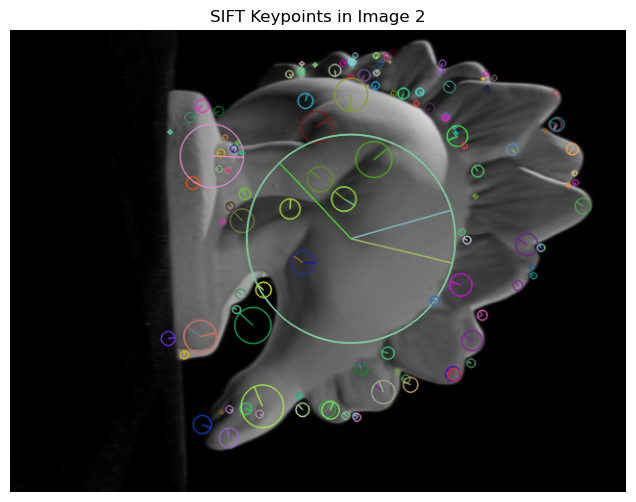

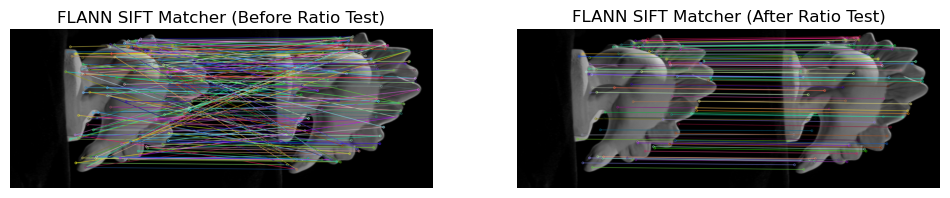

In [7]:
plot_keypoints(images[0], feature_descriptors[0][0], "SIFT Keypoints in Image 1")
plot_keypoints(images[1], feature_descriptors[1][0], "SIFT Keypoints in Image 2")
plot_matches(images[0], feature_descriptors[0][0], images[1], feature_descriptors[1][0], matches_flann_sift, good_matches_flann_sift, "FLANN SIFT Matcher")

In [15]:
# extract points
pts1 = []
pts2 = []
for i, (m) in enumerate(good_matches_flann_sift):
    pts2.append(feature_descriptors[1][0][m.trainIdx].pt)
    pts1.append(feature_descriptors[0][0][m.queryIdx].pt)
pts1 = np.asarray(pts1)
pts2 = np.asarray(pts2)

# Convert points to homogeneous coordinates
points1_h = cv2.convertPointsToHomogeneous(pts1).reshape(-1, 3)
points2_h = cv2.convertPointsToHomogeneous(pts2).reshape(-1, 3)

image_1_params = images_and_params[0, 0]
image_2_params = images_and_params[1, 0]

# Compute the projection matrices for the two cameras
P1 = image_1_params[1] @ np.hstack(
    (np.eye(3), np.zeros((3, 1)))
)  # Projection matrix for the first camera
P2 = image_2_params[1] @ np.hstack(
    (image_2_params[2], image_1_params[3])
)  # Projection matrix for the second camera

# Perform triangulation to get 3D points
points_4d_hom = cv2.triangulatePoints(
    P1,
    P2,
    np.asarray(pts1).T,
    np.asarray(pts2).T,
)

# Convert from homogeneous coordinates to 3D
points_3d = points_4d_hom[:3] / points_4d_hom[3]

In [16]:
visualize_point_cloud(points_3d)